In [ ]:
!pip install finlab


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.6 MB/s eta 0:00:00


In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

--2023-04-27 06:03:02--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-04-27 06:03:03--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-04-27 06:03:03--  http://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving cfhcable.dl.s

pairs trading

In [ ]:
import finlab
from finlab import data
from finlab.backtest import sim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

finlab.login('key')


收盤價 = data.get("price:收盤價")
收盤價.dropna(axis='columns')
#print(收盤價)
info = data.get('company_basic_info')
shares = info.loc[:,["stock_id","已發行普通股數或TDR原發行股數"]]
def filter(k):
  market_value = []
  for i in range(len(收盤價)):
    share = []
    stock_name = 收盤價.columns[i]
    price = 收盤價.loc[收盤價.index[k],stock_name]
    share.append(stock_name)
    #print(share)
    value = shares.loc[shares["stock_id"]==stock_name, "已發行普通股數或TDR原發行股數"].values
    if not value:
      value = np.append(value, 0)
    value = price*value
    share.append(value[0])
    if str(share[1])=='nan':
      del share[-1]
      share.append(0)
    #print(share)
    market_value.append(share)
  market_value.sort(key=lambda x:x[1])
  stock_list = []
  for i in range(1,401):
    name = market_value[-i][0]
    stock_list.append(name)
  #print(stock_list)
  return stock_list

# normalzie price
def normalize_data(stock_list):
  normalization = pd.DataFrame()
  for i in range(0,len(收盤價)):
    if 收盤價.columns[i] in stock_list:
      df = 收盤價.iloc[:,i]
      max = df.max()
      min = df.min()
      df = round((df-min)/(max-min),4)
      normalization = pd.concat([normalization, df], axis = 1)
      stock_name = normalization.columns
  return normalization, list(stock_name)
# print(stock_name)
# print('sadf')
# print(normalization)
# normalization.iloc[:,]
# fig = plt.figure()
# plt.plot(normalization.iloc[:,[6,8]],'-')

#euclidean distance
def euclidean_dist(k, normalization):
  all_dist = np.empty((0, 400), float)
  for i in range(0,400):
    all_list = [999] * (i+1)
    dist = []
    for j in range(i+1,len(normalization.columns)):
      num = round(math.dist(normalization.iloc[k-246:k,i], normalization.iloc[k-246:k,j]),4)

      if num == math.nan:
        dist.append(999)
      dist.append(num)

    all_list.extend(dist)
    all_dist = np.append(all_dist,np.array([all_list]),axis=0)
  return all_dist
#print(all_dist)
def update_dist(all_dist, k, normalization):
  for i in range(0,400):
    dist = all_dist[i]
    for j in range(i+1,len(normalization.columns)):
       dist[j]+= round(math.dist(normalization.iloc[k,i], normalization.iloc[k,j]),4)
    all_dist[i] = dist
  return all_dist


#find 20th smallest
def smallest(all_dist, stock_name):
  index_array = np.argpartition(all_dist.flatten(), kth=20)[:20]
  count = [0] * 400
  new_index_array = []
  name_index_array = []
  for i in range(20):
    if (count[index_array[i] // all_dist.shape[1]]==0 and count[index_array[i] % all_dist.shape[1]]==0):
      name_index_array.append([stock_name[index_array[i] // all_dist.shape[1]], stock_name[index_array[i] % all_dist.shape[1]]])
      new_index_array.append([index_array[i] // all_dist.shape[1], index_array[i] % all_dist.shape[1]])
      count[index_array[i] // all_dist.shape[1]]=1
      count[index_array[i] % all_dist.shape[1]]=1
  new_index_array = np.array(new_index_array)
  return new_index_array, name_index_array

# print(new_index_array)
# print(normalization.shape)
# print(new_index_array[0][0], new_index_array[0][1])
# print(all_dist[new_index_array[0][0], new_index_array[0][1]])
# print(round(math.dist(normalization.iloc[:,new_index_array[0][0]], normalization.iloc[:,new_index_array[0][1]]), 4))

#get pairs information
def get_pair(new_index_array, name_index_array, normalization):
  pair = []
  pair_mean = []
  pair_diff_normalization = pd.DataFrame()
  for i in range(len(name_index_array)):
    pair.append(normalization.iloc[:,[new_index_array[i][0], new_index_array[i][1]]])
    df = pair[i].iloc[:, 0] - pair[i].iloc[:, 1]
    pair_diff_normalization[i] = (df-df.mean())/df.std()
    pair_mean.append(df.mean())
  return pair_diff_normalization, pair_mean

# print(pair)
# print(pair_diff_normalization)
stock_list = filter(0)
normalization, stock_name = normalize_data(stock_list)
print(normalization)
print(stock_name)

輸入成功!


<ipython-input-14-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


              1101    1102    1103    1104    1110    1201    1210    1216  \
2013-01-02  0.5613  0.5417  0.3879  0.1060  0.2358  0.5182  0.2994  0.1939   
2013-01-03  0.5551  0.5437  0.3913  0.1157  0.2547  0.5171  0.2965  0.1939   
2013-01-04  0.5613  0.5317  0.3845  0.1301  0.2075  0.5137  0.2994  0.2078   
2013-01-07  0.5572  0.5238  0.3913  0.1470  0.2453  0.5421  0.3067  0.1911   
2013-01-08  0.5405  0.5179  0.3948  0.1518  0.2547  0.5319  0.3081  0.1884   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2020-12-25  0.7193  0.7500  0.7215  0.4313  0.9340  0.1401  0.9157  0.5374   
2020-12-28  0.7277  0.7639  0.7318  0.4795  0.9528  0.1526  1.0000  0.5540   
2020-12-29  0.7277  0.7698  0.7352  0.4554  0.9717  0.1538  0.9797  0.5540   
2020-12-30  0.7380  0.7679  0.7455  0.4578  1.0000  0.1481  0.9695  0.5789   
2020-12-31  0.7360  0.7698  0.7455  0.4458  0.9811  0.1481  0.9942  0.5706   

              1218    1227  ...    6803    8011    8039    8044

In [ ]:
# print(收盤價.iloc[:,400:800])
# print('sadf')
# print(normalization)
# print(first_two_years.columns[400:800])
print(all_dist)
print(new_index_array)
print(new_index_array)
# print(stock_name[224], stock_name[337])
# print(all_dist[224][337])
print(name_index_array)

進出場訊號

修正版

In [ ]:
#print(normalization.index)
def trade_period(k, position, pair_diff_normalization, name_index_array, pair_mean):
  name_index_array = np.array(name_index_array)
  for i in range(k, k+120):
    for j in range(0,len(name_index_array)):
      num=len(name_index_array)
      if(pair_mean[j] > 0):
        stock1 = name_index_array[j][0]
        stock2 = name_index_array[j][1]
      else:
        stock1 = name_index_array[j][1]
        stock2 = name_index_array[j][0]
      #print(type(position.loc[position.index[i],[stock1]]))
      if(pair_diff_normalization.iloc[i,j]>=1 and pair_diff_normalization.iloc[i-2,j]<1):
        # print(position.loc[position.index[i],[stock1]])
        position.loc[position.index[i],[stock1]] = -1
        print("sell "+ stock1)
        position.loc[position.index[i],[stock2]] = 1
        print("buy "+ stock2)
        print(position.index[i])
        #print(1)
      elif(pair_diff_normalization.iloc[i,j]<=-1 and pair_diff_normalization.iloc[i-2,j]>-1):
        # print(position.loc[position.index[i],[stock1]])
        position.loc[position.index[i],[stock1]] = 1
        print("buy "+ stock1)
        position.loc[position.index[i],[stock2]] = -1
        print("sell "+ stock2)
        print(position.index[i])
        #print(2)
      elif(pair_diff_normalization.iloc[i,j]>=0 and pair_diff_normalization.iloc[i-2,j]<=0):
        position.loc[position.index[i],[stock1]] = 0
        #print("take "+ stock1)
        position.loc[position.index[i],[stock2]] = 0
        #print("take "+ stock2)
        #print(position.index[i])
        #print(0)
      elif(pair_diff_normalization.iloc[i,j]<=0 and pair_diff_normalization.iloc[i-2,j]>=0):
        position.loc[position.index[i],[stock1]] = 0
        #print("take "+ stock1)
        position.loc[position.index[i],[stock2]] = 0
        #print("take "+ stock2)
        #print(position.index[i])
        #print(0)
      elif(pair_diff_normalization.iloc[i,j]>=2 and pair_diff_normalization.iloc[i-2,j]<2):
        # print(position.loc[position.index[i],[stock1]])
        position.loc[position.index[i],[stock1]] = 0
        print("stop "+ stock1)
        position.loc[position.index[i],[stock2]] = 0
        print("stop "+ stock2)
        #print(position.index[i])
        #print(name_index_array)
        #print([stock1,stock2])
        index = np.argwhere(name_index_array==[stock1])
        #print(index)
        a = index[0][0]*2
        b =a+1
        name_index_array = np.delete(name_index_array, [a,b])
        name_index_array = np.reshape(name_index_array, (num-1,-1))
        #print(name_index_array)
      elif(pair_diff_normalization.iloc[i,j]<=-2 and pair_diff_normalization.iloc[i-2,j]>-2):
        # print(position.loc[position.index[i],[stock1]])
        position.loc[position.index[i],[stock1]] = 0
        print("stop "+ stock1)
        position.loc[position.index[i],[stock2]] = 0
        print("stop "+ stock2)
        #print(position.index[i])
        #print(name_index_array)
        #print([stock1,stock2])
        index = np.argwhere(name_index_array==[stock1])
        #print(index)
        #print(type(name_index_array))
        a = index[0][0]*2
        b =a+1
        name_index_array = np.delete(name_index_array, [a,b])
        name_index_array = np.reshape(name_index_array, (num-1,-1))
        #print(name_index_array)
      else:
        position.loc[position.index[i], [stock1]] = position.loc[position.index[i-1], [stock1]]
        position.loc[position.index[i], [stock2]] = position.loc[position.index[i-1], [stock2]]
      if(i==k+119):
        position.loc[position.index[i],[stock1]] = 0
        position.loc[position.index[i],[stock2]] = 0
      if(j==len(name_index_array)-1):
        break
  return position

# print(position)


原始版

In [ ]:
#print(normalization.index)
def trade_period(k, position, pair_diff_normalization, name_index_array, pair_mean):
  for i in range(k, k+120):
    for j in range(0,len(name_index_array)):
      num=len(name_index_array)
      if(pair_mean[j] > 0):
        stock1 = name_index_array[j][0]
        stock2 = name_index_array[j][1]
      else:
        stock1 = name_index_array[j][1]
        stock2 = name_index_array[j][0]
      #print(type(position.loc[position.index[i],[stock1]]))
      if(pair_diff_normalization.iloc[i,j]>=1 and pair_diff_normalization.iloc[i-2,j]<1):
        # print(position.loc[position.index[i],[stock1]])
        position.loc[position.index[i],[stock1]] = -1
        print("sell "+ stock1)
        position.loc[position.index[i],[stock2]] = 1
        print("buy "+ stock2)
        print(position.index[i])
        #print(1)
      elif(pair_diff_normalization.iloc[i,j]<=-1 and pair_diff_normalization.iloc[i-2,j]>-1):
        # print(position.loc[position.index[i],[stock1]])
        position.loc[position.index[i],[stock1]] = 1
        print("buy "+ stock1)
        position.loc[position.index[i],[stock2]] = -1
        print("sell "+ stock2)
        print(position.index[i])
        #print(2)
      elif(pair_diff_normalization.iloc[i,j]>=0 and pair_diff_normalization.iloc[i-2,j]<=0):
        position.loc[position.index[i],[stock1]] = 0
        #print("take "+ stock1)
        position.loc[position.index[i],[stock2]] = 0
        #print("take "+ stock2)
        #print(position.index[i])
        #print(0)
      elif(pair_diff_normalization.iloc[i,j]<=0 and pair_diff_normalization.iloc[i-2,j]>=0):
        position.loc[position.index[i],[stock1]] = 0
        #print("take "+ stock1)
        position.loc[position.index[i],[stock2]] = 0
        #print("take "+ stock2)
        #print(position.index[i])
        #print(0)
      elif(pair_diff_normalization.iloc[i,j]>=2 and pair_diff_normalization.iloc[i-2,j]<2):
        # print(position.loc[position.index[i],[stock1]])
        position.loc[position.index[i],[stock1]] = 0
        #print("stop "+ stock1)
        position.loc[position.index[i],[stock2]] = 0
        #print("stop "+ stock2)
        #print(position.index[i])
        print(name_index_array)

      elif(pair_diff_normalization.iloc[i,j]<=-2 and pair_diff_normalization.iloc[i-2,j]>-2):
        # print(position.loc[position.index[i],[stock1]])
        position.loc[position.index[i],[stock1]] = 0
        #print("stop "+ stock1)
        position.loc[position.index[i],[stock2]] = 0
        #print("stop "+ stock2)
        #print(position.index[i])
        print(name_index_array)

      else:
        position.loc[position.index[i], [stock1]] = position.loc[position.index[i-1], [stock1]]
        position.loc[position.index[i], [stock2]] = position.loc[position.index[i-1], [stock2]]
      if(i==k+119):
        position.loc[position.index[i],[stock1]] = 0
        position.loc[position.index[i],[stock2]] = 0
      if(j==len(name_index_array)-1):
        break
  return position

# print(position)


In [ ]:
finlab.login('3+h4Fdg16bd02h9+vlzJ0UN9ivzo7Q5Hl5xUXOYMTNEuZW/x5ooa3eLr+6wz/kNk#free')
position = 收盤價-收盤價
position = position.fillna(0)
for k in range(246, 246*7, 120):
  print("pair change")
  stock_list = filter(0)
  normalization, stock_name = normalize_data(stock_list)
  all_dist = euclidean_dist(k, normalization)
  new_index_array, name_index_array = smallest(all_dist, stock_name)
  pair_diff_normalization, pair_mean = get_pair(new_index_array, name_index_array, normalization)
  position = trade_period(k, position, pair_diff_normalization, name_index_array, pair_mean)
report = sim(position, resample=None)

輸入成功!
pair change


<ipython-input-14-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


sell 2408
buy 2345
2014-01-16 00:00:00
sell 2408
buy 2345
2014-01-17 00:00:00
sell 2441
buy 3008
2014-04-16 00:00:00
sell 2441
buy 3008
2014-04-17 00:00:00
sell 2441
buy 3008
2014-05-05 00:00:00
sell 2441
buy 3008
2014-05-06 00:00:00
sell 3532
buy 2027
2014-05-12 00:00:00
sell 3532
buy 2027
2014-05-13 00:00:00
sell 2408
buy 2345
2014-05-15 00:00:00
sell 2441
buy 3008
2014-06-25 00:00:00
sell 2441
buy 3008
2014-07-02 00:00:00
pair change


<ipython-input-14-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


sell 3023
buy 2379
2014-08-11 00:00:00
sell 3023
buy 2379
2014-08-12 00:00:00
stop 3023
stop 2379
stop 6182
stop 1904
buy 2337
sell 2615
2014-10-06 00:00:00
buy 2408
sell 2330
2014-10-20 00:00:00
buy 2408
sell 2330
2014-10-21 00:00:00
buy 2337
sell 2615
2014-10-22 00:00:00
buy 2337
sell 2615
2014-10-23 00:00:00
buy 2337
sell 2615
2014-11-05 00:00:00
buy 2337
sell 2615
2014-11-11 00:00:00
buy 2337
sell 2615
2014-11-14 00:00:00
buy 2337
sell 2615
2014-11-17 00:00:00
pair change


<ipython-input-14-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


buy 1229
sell 2303
2014-12-27 00:00:00
buy 1229
sell 2303
2015-01-05 00:00:00
sell 3227
buy 4966
2015-01-14 00:00:00
sell 3227
buy 4966
2015-01-15 00:00:00
buy 3005
sell 3532
2015-01-19 00:00:00
sell 3227
buy 4966
2015-01-27 00:00:00
sell 3227
buy 4966
2015-02-11 00:00:00
sell 3227
buy 4966
2015-02-24 00:00:00
stop 3227
stop 4966
stop 2371
stop 4128
buy 2379
sell 5469
2015-03-09 00:00:00
stop 1808
stop 6182
buy 1229
sell 2303
2015-04-01 00:00:00
buy 1229
sell 2303
2015-04-02 00:00:00
pair change


<ipython-input-14-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


pair change


<ipython-input-14-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


buy 2031
sell 2208
2016-01-22 00:00:00
sell 3443
buy 3293
2016-02-03 00:00:00
sell 3443
buy 3293
2016-02-15 00:00:00
sell 3443
buy 3293
2016-02-22 00:00:00
sell 3443
buy 3293
2016-02-23 00:00:00
sell 3443
buy 3293
2016-02-26 00:00:00
sell 3443
buy 3293
2016-03-03 00:00:00
sell 3443
buy 3293
2016-03-10 00:00:00
sell 3443
buy 3293
2016-03-15 00:00:00
sell 3443
buy 3293
2016-03-21 00:00:00
buy 2031
sell 2208
2016-04-06 00:00:00
buy 2031
sell 2208
2016-04-07 00:00:00
pair change


<ipython-input-14-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


buy 3622
sell 4933
2016-06-22 00:00:00
buy 3622
sell 4933
2016-06-23 00:00:00
pair change


<ipython-input-14-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


pair change


<ipython-input-14-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


sell 6213
buy 2345
2017-06-13 00:00:00
sell 6213
buy 2345
2017-06-19 00:00:00
sell 3034
buy 2303
2017-06-30 00:00:00
sell 6213
buy 2345
2017-07-04 00:00:00
sell 3034
buy 2303
2017-07-11 00:00:00
sell 3034
buy 2303
2017-07-12 00:00:00
sell 4933
buy 3673
2017-08-04 00:00:00
sell 2903
buy 1722
2017-08-07 00:00:00
sell 4933
buy 3673
2017-08-07 00:00:00
sell 2903
buy 1722
2017-08-08 00:00:00
buy 5531
sell 6120
2017-08-25 00:00:00
buy 5531
sell 6120
2017-08-28 00:00:00
sell 4933
buy 3673
2017-10-06 00:00:00
sell 4933
buy 3673
2017-10-13 00:00:00
sell 2367
buy 3037
2017-11-29 00:00:00
pair change


<ipython-input-14-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


buy 4168
sell 1337
2018-03-27 00:00:00
buy 4168
sell 1337
2018-03-28 00:00:00
sell 2903
buy 2208
2018-04-09 00:00:00
buy 4168
sell 1337
2018-04-09 00:00:00
sell 2903
buy 2208
2018-04-10 00:00:00
sell 2903
buy 2208
2018-04-20 00:00:00
pair change


<ipython-input-14-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


sell 4142
buy 4128
2018-06-01 00:00:00
sell 4142
buy 4128
2018-06-04 00:00:00
sell 4142
buy 4128
2018-06-14 00:00:00
sell 2504
buy 2108
2018-07-17 00:00:00
sell 2504
buy 2108
2018-07-18 00:00:00
buy 2201
sell 2913
2018-08-06 00:00:00
sell 2504
buy 2108
2018-08-08 00:00:00
sell 2504
buy 2108
2018-08-09 00:00:00
sell 2504
buy 2108
2018-10-01 00:00:00
sell 2504
buy 2108
2018-10-02 00:00:00
sell 2504
buy 2108
2018-10-08 00:00:00
sell 2504
buy 2108
2018-10-12 00:00:00
buy 2201
sell 2913
2018-10-19 00:00:00
buy 2201
sell 2913
2018-10-22 00:00:00
pair change


<ipython-input-14-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


buy 2106
sell 3576
2019-04-15 00:00:00
buy 2106
sell 3576
2019-05-07 00:00:00
buy 2106
sell 3576
2019-05-08 00:00:00
pair change


<ipython-input-14-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


buy 2106
sell 2603
2019-07-01 00:00:00
buy 2106
sell 2603
2019-07-02 00:00:00
sell 4168
buy 2504
2019-10-16 00:00:00
sell 4168
buy 2504
2019-10-17 00:00:00
pair change


<ipython-input-14-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


buy 4141
sell 8011
2019-11-26 00:00:00
buy 4141
sell 8011
2019-12-10 00:00:00
buy 4141
sell 8011
2019-12-11 00:00:00
sell 8076
buy 1513
2020-01-16 00:00:00
sell 8076
buy 1513
2020-01-17 00:00:00
buy 4141
sell 8011
2020-02-19 00:00:00
sell 3691
buy 2406
2020-03-06 00:00:00
buy 1789
sell 1337
2020-03-09 00:00:00
sell 8076
buy 1513
2020-04-27 00:00:00
sell 8076
buy 1513
2020-04-30 00:00:00
buy 4141
sell 8011
2020-04-30 00:00:00
buy 4141
sell 8011
2020-05-04 00:00:00
sell 8076
buy 1513
2020-05-08 00:00:00


市值後400

In [ ]:
finlab.login('3+h4Fdg16bd02h9+vlzJ0UN9ivzo7Q5Hl5xUXOYMTNEuZW/x5ooa3eLr+6wz/kNk#free')
position = 收盤價-收盤價
position = position.fillna(0)
for k in range(246, 246*7, 120):
  print("pair change")
  stock_list = filter(0)
  normalization, stock_name = normalize_data(stock_list)
  all_dist = euclidean_dist(k, normalization)
  new_index_array, name_index_array = smallest(all_dist, stock_name)
  pair_diff_normalization, pair_mean = get_pair(new_index_array, name_index_array, normalization)
  position = trade_period(k, position, pair_diff_normalization, name_index_array, pair_mean)
report = sim(position, resample=None)

輸入成功!
pair change


<ipython-input-8-2144d940ef7d>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


sell 6274
buy 5457
2014-06-03 00:00:00
sell 6274
buy 5457
2014-06-04 00:00:00
sell 6173
buy 2478
2014-06-06 00:00:00
sell 6274
buy 5457
2014-06-09 00:00:00
sell 6274
buy 5457
2014-06-10 00:00:00
buy 3529
sell 2368
2014-06-25 00:00:00
buy 3529
sell 2368
2014-06-26 00:00:00
pair change


<ipython-input-8-2144d940ef7d>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


sell 6274
buy 3669
2014-07-22 00:00:00
sell 6274
buy 3669
2014-07-24 00:00:00
sell 3324
buy 2387
2014-08-01 00:00:00
sell 3324
buy 2387
2014-08-04 00:00:00
sell 2478
buy 2368
2014-12-01 00:00:00
sell 2478
buy 2368
2014-12-02 00:00:00
pair change


<ipython-input-8-2144d940ef7d>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


sell 4205
buy 2417
2015-02-10 00:00:00
sell 4205
buy 2417
2015-02-11 00:00:00
pair change


<ipython-input-8-2144d940ef7d>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


pair change


<ipython-input-8-2144d940ef7d>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


buy 3563
sell 6173
2016-03-11 00:00:00
buy 3563
sell 6173
2016-03-14 00:00:00
buy 3563
sell 6173
2016-05-10 00:00:00
buy 3563
sell 6173
2016-05-23 00:00:00
buy 3563
sell 6173
2016-05-24 00:00:00
buy 3563
sell 6173
2016-06-15 00:00:00
pair change


<ipython-input-8-2144d940ef7d>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


pair change


<ipython-input-8-2144d940ef7d>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


buy 2323
sell 6196
2017-04-26 00:00:00
buy 2323
sell 6196
2017-04-27 00:00:00
buy 2323
sell 6196
2017-06-09 00:00:00
buy 2323
sell 6196
2017-06-12 00:00:00
pair change


<ipython-input-8-2144d940ef7d>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


buy 3090
sell 6173
2017-08-17 00:00:00
buy 3090
sell 6173
2017-08-18 00:00:00
stop 3090
stop 6173
stop 1315
stop 3669
buy 2323
sell 3311
2017-11-20 00:00:00
buy 2323
sell 3311
2017-11-21 00:00:00
pair change


<ipython-input-8-2144d940ef7d>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


buy 2425
sell 2390
2018-02-27 00:00:00
buy 2425
sell 2390
2018-03-01 00:00:00
sell 6125
buy 3624
2018-03-05 00:00:00
sell 6125
buy 3624
2018-03-06 00:00:00
buy 2425
sell 2390
2018-03-20 00:00:00
buy 2425
sell 2390
2018-03-21 00:00:00
sell 6125
buy 3624
2018-03-21 00:00:00
sell 6125
buy 3624
2018-03-22 00:00:00
sell 6125
buy 3624
2018-03-27 00:00:00
sell 6125
buy 3624
2018-03-28 00:00:00
sell 1514
buy 5609
2018-04-02 00:00:00
sell 1514
buy 5609
2018-04-03 00:00:00
stop 1514
stop 5609
stop 2611
stop 2705
sell 6125
buy 3624
2018-04-16 00:00:00
stop 1414
stop 3090
sell 6125
buy 3624
2018-04-17 00:00:00
sell 6125
buy 3624
2018-05-10 00:00:00
sell 6125
buy 3624
2018-05-11 00:00:00
buy 2425
sell 2390
2018-05-22 00:00:00
buy 2425
sell 2390
2018-05-23 00:00:00
stop 6125
stop 3624
stop 5225
stop 1734
pair change


<ipython-input-8-2144d940ef7d>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


sell 8054
buy 5355
2018-06-25 00:00:00
sell 8054
buy 5355
2018-06-29 00:00:00
sell 8054
buy 5355
2018-07-02 00:00:00
sell 8054
buy 5355
2018-07-27 00:00:00
sell 8054
buy 5355
2018-07-30 00:00:00
sell 4942
buy 6152
2018-11-12 00:00:00
sell 4942
buy 6152
2018-11-13 00:00:00
pair change


<ipython-input-8-2144d940ef7d>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


sell 4523
buy 3704
2019-01-09 00:00:00
sell 4523
buy 3704
2019-01-10 00:00:00
sell 4523
buy 3704
2019-04-01 00:00:00
sell 4523
buy 3704
2019-04-12 00:00:00
sell 4523
buy 3704
2019-04-15 00:00:00
stop 4523
stop 3704
pair change


<ipython-input-8-2144d940ef7d>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


sell 3373
buy 3218
2019-09-02 00:00:00
sell 3373
buy 3218
2019-09-03 00:00:00
sell 3373
buy 3218
2019-09-11 00:00:00
sell 3373
buy 3218
2019-09-17 00:00:00
sell 3373
buy 3218
2019-09-24 00:00:00
sell 3373
buy 3218
2019-09-25 00:00:00
sell 3687
buy 4702
2019-09-26 00:00:00
sell 3687
buy 4702
2019-09-27 00:00:00
sell 3373
buy 3218
2019-10-02 00:00:00
sell 3373
buy 3218
2019-10-03 00:00:00
sell 3373
buy 3218
2019-10-08 00:00:00
sell 3373
buy 3218
2019-10-17 00:00:00
sell 3680
buy 5529
2019-10-21 00:00:00
sell 3680
buy 5529
2019-10-22 00:00:00
buy 1734
sell 6185
2019-11-18 00:00:00
pair change


<ipython-input-8-2144d940ef7d>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


buy 4133
sell 3669
2020-05-18 00:00:00
buy 4106
sell 3058
2020-05-18 00:00:00
buy 4133
sell 3669
2020-05-19 00:00:00
buy 4106
sell 3058
2020-05-19 00:00:00
sell 5355
buy 1309
2020-05-20 00:00:00


市值前400

In [ ]:
finlab.login('3+h4Fdg16bd02h9+vlzJ0UN9ivzo7Q5Hl5xUXOYMTNEuZW/x5ooa3eLr+6wz/kNk#free')
position = 收盤價-收盤價
position = position.fillna(0)
for k in range(246, 246*7, 120):
  print("pair change")
  stock_list = filter(0)
  normalization, stock_name = normalize_data(stock_list)
  all_dist = euclidean_dist(k, normalization)
  new_index_array, name_index_array = smallest(all_dist, stock_name)
  pair_diff_normalization, pair_mean = get_pair(new_index_array, name_index_array, normalization)
  position = trade_period(k, position, pair_diff_normalization, name_index_array, pair_mean)
report = sim(position, resample=None)

輸入成功!
pair change


<ipython-input-2-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


sell 2408
buy 2345
2014-01-16 00:00:00
sell 2408
buy 2345
2014-01-17 00:00:00
sell 2441
buy 3008
2014-04-16 00:00:00
sell 2441
buy 3008
2014-04-17 00:00:00
sell 2441
buy 3008
2014-05-05 00:00:00
sell 2441
buy 3008
2014-05-06 00:00:00
sell 3532
buy 2027
2014-05-12 00:00:00
sell 3532
buy 2027
2014-05-13 00:00:00
sell 2408
buy 2345
2014-05-15 00:00:00
sell 2441
buy 3008
2014-06-25 00:00:00
sell 2441
buy 3008
2014-07-02 00:00:00
pair change


<ipython-input-2-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


sell 3023
buy 2379
2014-08-11 00:00:00
sell 3023
buy 2379
2014-08-12 00:00:00
stop 3023
stop 2379
stop 6182
stop 1904
buy 2337
sell 2615
2014-10-06 00:00:00
buy 2408
sell 2330
2014-10-20 00:00:00
buy 2408
sell 2330
2014-10-21 00:00:00
buy 2337
sell 2615
2014-10-22 00:00:00
buy 2337
sell 2615
2014-10-23 00:00:00
buy 2337
sell 2615
2014-11-05 00:00:00
buy 2337
sell 2615
2014-11-11 00:00:00
buy 2337
sell 2615
2014-11-14 00:00:00
buy 2337
sell 2615
2014-11-17 00:00:00
pair change


<ipython-input-2-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


buy 1229
sell 2303
2014-12-27 00:00:00
buy 1229
sell 2303
2015-01-05 00:00:00
sell 3227
buy 4966
2015-01-14 00:00:00
sell 3227
buy 4966
2015-01-15 00:00:00
buy 3005
sell 3532
2015-01-19 00:00:00
sell 3227
buy 4966
2015-01-27 00:00:00
sell 3227
buy 4966
2015-02-11 00:00:00
sell 3227
buy 4966
2015-02-24 00:00:00
stop 3227
stop 4966
stop 2371
stop 4128
buy 2379
sell 5469
2015-03-09 00:00:00
stop 1808
stop 6182
buy 1229
sell 2303
2015-04-01 00:00:00
buy 1229
sell 2303
2015-04-02 00:00:00
pair change


<ipython-input-2-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


pair change


<ipython-input-2-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


buy 2031
sell 2208
2016-01-22 00:00:00
sell 3443
buy 3293
2016-02-03 00:00:00
sell 3443
buy 3293
2016-02-15 00:00:00
sell 3443
buy 3293
2016-02-22 00:00:00
sell 3443
buy 3293
2016-02-23 00:00:00
sell 3443
buy 3293
2016-02-26 00:00:00
sell 3443
buy 3293
2016-03-03 00:00:00
sell 3443
buy 3293
2016-03-10 00:00:00
sell 3443
buy 3293
2016-03-15 00:00:00
sell 3443
buy 3293
2016-03-21 00:00:00
buy 2031
sell 2208
2016-04-06 00:00:00
buy 2031
sell 2208
2016-04-07 00:00:00
pair change


<ipython-input-2-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


buy 3622
sell 4933
2016-06-22 00:00:00
buy 3622
sell 4933
2016-06-23 00:00:00
pair change


<ipython-input-2-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


pair change


<ipython-input-2-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


sell 6213
buy 2345
2017-06-13 00:00:00
sell 6213
buy 2345
2017-06-19 00:00:00
sell 3034
buy 2303
2017-06-30 00:00:00
sell 6213
buy 2345
2017-07-04 00:00:00
sell 3034
buy 2303
2017-07-11 00:00:00
sell 3034
buy 2303
2017-07-12 00:00:00
sell 4933
buy 3673
2017-08-04 00:00:00
sell 2903
buy 1722
2017-08-07 00:00:00
sell 4933
buy 3673
2017-08-07 00:00:00
sell 2903
buy 1722
2017-08-08 00:00:00
buy 5531
sell 6120
2017-08-25 00:00:00
buy 5531
sell 6120
2017-08-28 00:00:00
sell 4933
buy 3673
2017-10-06 00:00:00
sell 4933
buy 3673
2017-10-13 00:00:00
sell 2367
buy 3037
2017-11-29 00:00:00
pair change


<ipython-input-2-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


buy 4168
sell 1337
2018-03-27 00:00:00
buy 4168
sell 1337
2018-03-28 00:00:00
sell 2903
buy 2208
2018-04-09 00:00:00
buy 4168
sell 1337
2018-04-09 00:00:00
sell 2903
buy 2208
2018-04-10 00:00:00
sell 2903
buy 2208
2018-04-20 00:00:00
pair change


<ipython-input-2-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


sell 4142
buy 4128
2018-06-01 00:00:00
sell 4142
buy 4128
2018-06-04 00:00:00
sell 4142
buy 4128
2018-06-14 00:00:00
sell 2504
buy 2108
2018-07-17 00:00:00
sell 2504
buy 2108
2018-07-18 00:00:00
buy 2201
sell 2913
2018-08-06 00:00:00
sell 2504
buy 2108
2018-08-08 00:00:00
sell 2504
buy 2108
2018-08-09 00:00:00
sell 2504
buy 2108
2018-10-01 00:00:00
sell 2504
buy 2108
2018-10-02 00:00:00
sell 2504
buy 2108
2018-10-08 00:00:00
sell 2504
buy 2108
2018-10-12 00:00:00
buy 2201
sell 2913
2018-10-19 00:00:00
buy 2201
sell 2913
2018-10-22 00:00:00
pair change


<ipython-input-2-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


buy 2106
sell 3576
2019-04-15 00:00:00
buy 2106
sell 3576
2019-05-07 00:00:00
buy 2106
sell 3576
2019-05-08 00:00:00
pair change


<ipython-input-2-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


buy 2106
sell 2603
2019-07-01 00:00:00
buy 2106
sell 2603
2019-07-02 00:00:00
sell 4168
buy 2504
2019-10-16 00:00:00
sell 4168
buy 2504
2019-10-17 00:00:00
pair change


<ipython-input-2-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


buy 4141
sell 8011
2019-11-26 00:00:00
buy 4141
sell 8011
2019-12-10 00:00:00
buy 4141
sell 8011
2019-12-11 00:00:00
sell 8076
buy 1513
2020-01-16 00:00:00
sell 8076
buy 1513
2020-01-17 00:00:00
buy 4141
sell 8011
2020-02-19 00:00:00
sell 3691
buy 2406
2020-03-06 00:00:00
buy 1789
sell 1337
2020-03-09 00:00:00
sell 8076
buy 1513
2020-04-27 00:00:00
sell 8076
buy 1513
2020-04-30 00:00:00
buy 4141
sell 8011
2020-04-30 00:00:00
buy 4141
sell 8011
2020-05-04 00:00:00
sell 8076
buy 1513
2020-05-08 00:00:00


In [ ]:
finlab.login('3+h4Fdg16bd02h9+vlzJ0UN9ivzo7Q5Hl5xUXOYMTNEuZW/x5ooa3eLr+6wz/kNk#free')
position = 收盤價-收盤價
position = position.fillna(0)
for k in range(246*6, 246*7, 120):
  print("pair change")
  stock_list = filter(0)
  normalization, stock_name = normalize_data(stock_list)
  all_dist = euclidean_dist(k, normalization)
  new_index_array, name_index_array = smallest(all_dist, stock_name)
  pair_diff_normalization, pair_mean = get_pair(new_index_array, name_index_array, normalization)
  position = trade_period(k, position, pair_diff_normalization, name_index_array, pair_mean)
report = sim(position, resample=None)

輸入成功!
pair change


<ipython-input-26-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


buy 2707
sell 5508
2019-03-07 00:00:00
buy 2707
sell 5508
2019-03-08 00:00:00
buy 2545
sell 3149
2019-03-20 00:00:00
buy 2545
sell 3149
2019-03-21 00:00:00
buy 2106
sell 2603
2019-04-29 00:00:00
buy 2106
sell 2603
2019-04-30 00:00:00
buy 2106
sell 2603
2019-07-01 00:00:00
buy 2106
sell 2603
2019-07-02 00:00:00


<ipython-input-26-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


pair change
buy 1337
sell 3266
2019-08-19 00:00:00
buy 1337
sell 3266
2019-08-20 00:00:00
stop 1337
stop 3266
stop 2106
stop 4168
pair change


<ipython-input-26-29c255cf7d12>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not value:


buy 4141
sell 8011
2020-02-19 00:00:00
buy 4141
sell 8011
2020-04-30 00:00:00
buy 4141
sell 8011
2020-05-04 00:00:00
buy 4168
sell 4152
2020-05-26 00:00:00
buy 4168
sell 4152
2020-05-27 00:00:00
buy 3060
sell 4128
2020-06-03 00:00:00
buy 3060
sell 4128
2020-06-04 00:00:00
buy 4168
sell 4152
2020-06-10 00:00:00
buy 4168
sell 4152
2020-06-11 00:00:00
stop 3060
stop 4128
stop 4141
stop 8011


In [ ]:
#print(收盤價.iloc[:,1])
#print(normalization)
#print(first_two_years)
#print(all_dist)
print(new_index_array)
print(name_index_array)
#print(df)
#print(pair_mean)
#print(pair_diff_normalization)
normalization.iloc[:,126]
fig1 = plt.figure()
#plt.plot(pair_diff_normalization.iloc[:,0],'-')
fig2 = plt.figure()
#plt.plot(normalization.iloc[:,[224,337]],'-')
fig3 = plt.figure()
#plt.plot(pair_diff_normalization.iloc[:,1],'-')
fig4 = plt.figure()
#plt.plot(normalization.iloc[:,[277,307]],'-')

[[164 291]
 [258 304]
 [305 391]
 [261 271]
 [307 310]]
[['2498', '3673'], ['3060', '4128'], ['4141', '8011'], ['3149', '3356'], ['4152', '4168']]


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

[[164 291]
 [258 304]
 [305 391]
 [261 271]
 [307 310]]
[['2498', '3673'], ['3060', '4128'], ['4141', '8011'], ['3149', '3356'], ['4152', '4168']]


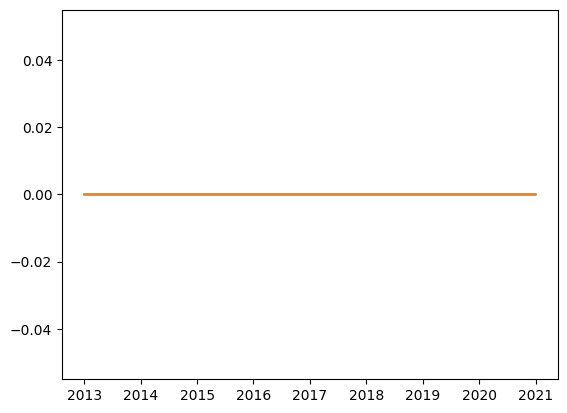

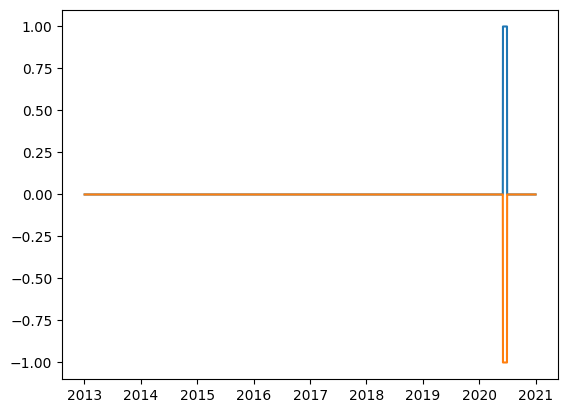

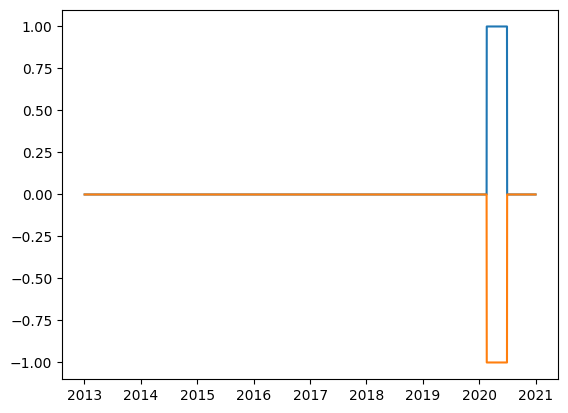

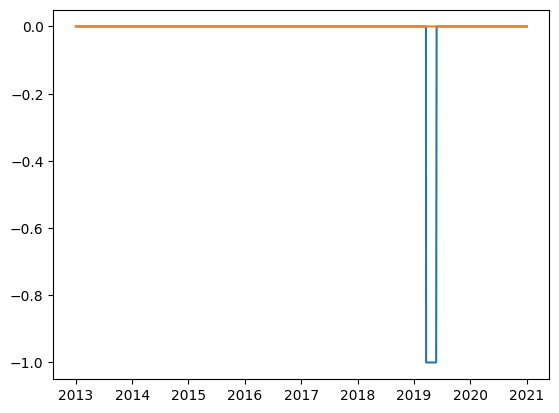

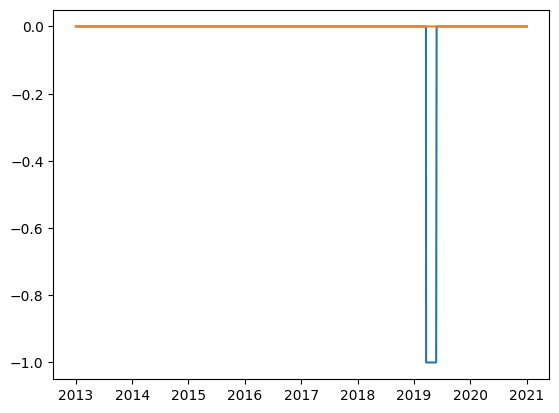

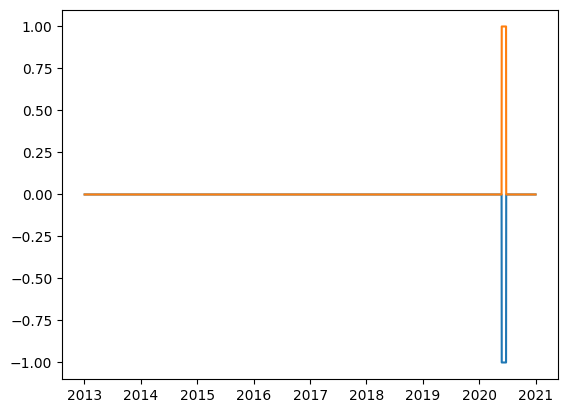

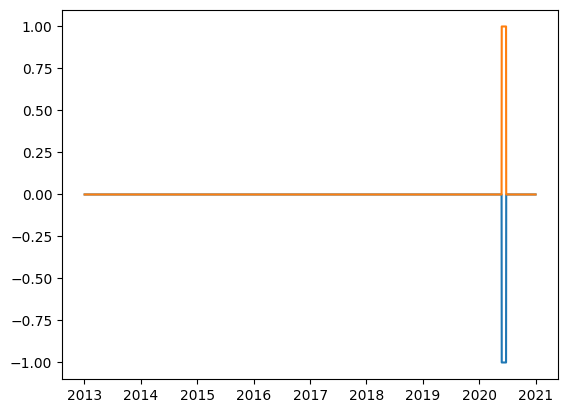

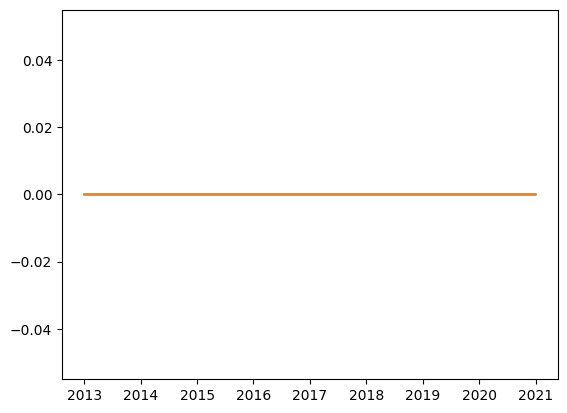

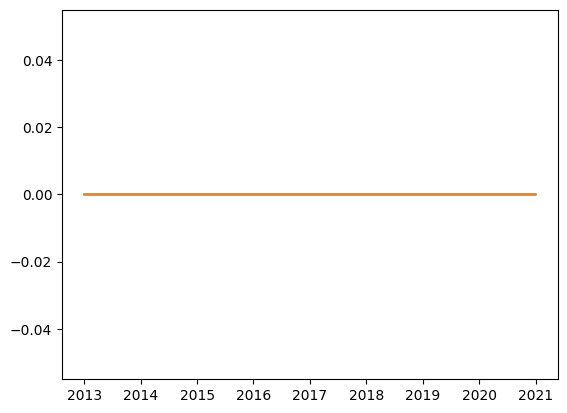

In [ ]:
pd.set_option('display.max_columns', None)
# 显示所有行
pd.set_option('display.max_rows', None)
#print(position.iloc[:,[171,173]])
print(new_index_array)
print(name_index_array)
fig1 = plt.figure()
plt.plot(position.loc[:,['2498', '3673']],'-')
fig2 = plt.figure()
plt.plot(position.loc[:,['3060', '4128']],'-')
fig3 = plt.figure()
plt.plot(position.loc[:,['4141', '8011']],'-')
fig4 = plt.figure()
plt.plot(position.loc[:,['3149', '3356']],'-')
fig5 = plt.figure()
plt.plot(position.loc[:,['3149', '3356']],'-')
fig6 = plt.figure()
plt.plot(position.loc[:,['4152', '4168']],'-')
fig7 = plt.figure()
plt.plot(position.loc[:,['4152', '4168']],'-')
fig8 = plt.figure()
plt.plot(position.loc[:,['2103', '6605']],'-')
fig9 = plt.figure()
plt.plot(position.loc[:,['1513', '8076']],'-')
#print(position.loc[:,['2337','2338','2377','2404','2302','2368']])

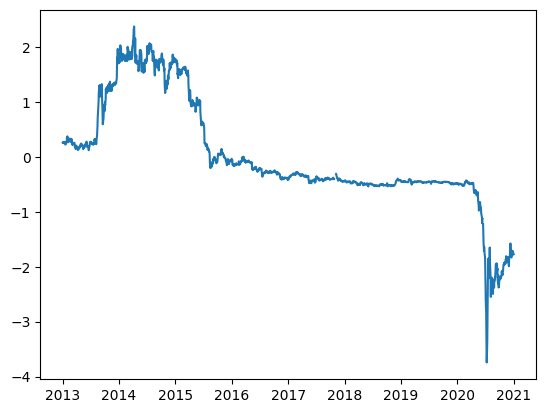

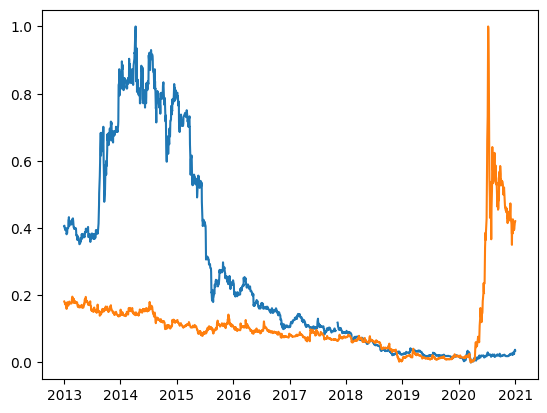

In [ ]:
fig1 = plt.figure()
plt.plot(pair_diff_normalization.iloc[:,1],'-')
fig2 = plt.figure()
plt.plot(normalization.loc[:,['3060', '4128']],'-')


In [ ]:
x = np.array([['111','2'],['3333','4555'],['5','6']])
index = np.argwhere(x==['3333','4555'])
print(index)
x = np.delete(x, [0,2], None)
print(x)


[[1 0]
 [1 1]]
['2' '4555' '5' '6']
